
# Language modeling with LSTM

Train a language model using a recurrent neural network. Work with individual words rather than letters.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)


In [ ]:
set_seed()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
all_sentences = dataset['train']['text'] + dataset['test']['text'] + dataset['unsupervised']['text']
random.shuffle(all_sentences)

# Split sizes
train_percent = 0.8
val_percent = 0.15
test_percent = 0.05

# Calculate the number of samples for each split
total_samples = len(all_sentences)
num_train = int(total_samples * train_percent)
num_val = int(total_samples * val_percent)
num_test = total_samples - num_train - num_val

# Split the shuffled sentences
train_rows = all_sentences[:num_train]
val_rows = all_sentences[num_train:num_train + num_val]
test_rows = all_sentences[num_train + num_val:]

print("Train dataset size:", len(train_rows))
print("Validation dataset size:", len(val_rows))
print("Test dataset size:", len(test_rows))

Train dataset size: 80000
Validation dataset size: 15000
Test dataset size: 5000


In [ ]:
def preprocess_sentences(rows, word_threshold):
  sentences = []
  for row in tqdm(rows):
    sentences.extend([sentence.lower() for sentence in sent_tokenize(row, language='english') if len(word_tokenize(sentence)) < word_threshold])
  return sentences


In [ ]:
word_threshold = 32
train_sentences = preprocess_sentences(train_rows, word_threshold)
eval_sentences = preprocess_sentences(val_rows, word_threshold)
test_sentences = preprocess_sentences(test_rows, word_threshold)


  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(train_sentences))

Всего предложений: 630279


In [ ]:
for sentence in train_sentences[:10]:
  print(sentence)
  print()



i am ashamed to say it, but i have to admit, the first time i saw this film was only about a year ago.

it works as your straight monster or action type film, as a horror/sci-fi and also as a very intriguing look into the human psyche.

the other cast members all carry off their roles with style, and the net result is an intensely believable atmosphere, and a truly fantastic film.

while visiting in london, i watched bleeder.

i liked it a lot.

haven't seen any other danish films, but this one is great.

one of the other people commenting here said it was made on a low budget.

i certainly wouldn't say it showed heavily.

there's no real expensive shots (crowd scenes, explosions, etc), but everything is shot to scale and looks good.

especially the cinematography.



Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(train_sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/630279 [00:00<?, ?it/s]

In [ ]:
len(words)

128198

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab_size = 40000

special_tokens = ['<unk>', '<bos>', '<eos>', '<pad>']
vocab = set(special_tokens + [word for word, _ in words.most_common(vocab_size)])

# Вывод первых 10 слов из словаря
for word in list(vocab)[:10]:
    print(word)

ghosh
jihad
suggest
pyaar
pastries
comparing
jeter
slumps
nicotine
shaming


In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


In [ ]:
chars = []
for word in vocab:
    if len(word) == 1:
      chars.append(word)

print(len(chars))
if len(chars) >= 5:
  print(chars[:5])

0


### Подготовка датасета (1 балл)


В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [ ]:
num_random_entries = 5

# Get a list of keys (indices) from the dictionary
keys = list(ind2word.keys())

print(f"Random entries from ind2word:")
for _ in range(num_random_entries):
    random_key = random.choice(keys)
    random_word = ind2word[random_key]
    print(f"Index: {random_key}, Word: {random_word}")

Random entries from ind2word:
Index: 19808, Word: packard
Index: 10027, Word: yacht
Index: 23308, Word: silents
Index: 17145, Word: thrower
Index: 39948, Word: yann


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        # self.data = [[self.tokenize_sentence(sentence)] for sentence in sentences]
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        words = word_tokenize(self.data[idx])  # Tokenize the sentence into words
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in words]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    max_seq_len = max(len(sequence) for sequence in input_batch)

    # Pad sequences to the same length
    padded_batch = [sequence + [pad_id] * (max_seq_len - len(sequence)) for sequence in input_batch]
    sequences = torch.LongTensor(padded_batch).to(device)

    # Separate input and target sequences
    input_ids = sequences[:, :-1]
    target_ids = sequences[:, 1:]

    return {'input_ids': input_ids, 'target_ids': target_ids}

In [ ]:
reduce_percent = 0.3
reduced_train_sentences = train_sentences[:int(len(train_sentences)*reduce_percent)]
len(reduced_train_sentences)


189083

In [ ]:
# TBD release : train_dataset = WordDataset(train_sentences)
train_dataset = WordDataset(reduced_train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 16 #128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
# Get one random batch from the train_dataloader
for batch in train_dataloader:
    # Extract input_ids and target_ids tensors from the batch
    input_ids = batch['input_ids']
    target_ids = batch['target_ids']

    num_examples = 1
    for i in range(num_examples):
        print(f"Example {i + 1}:")
        print("Input IDs:", input_ids[i][:5])
        print("Target IDs:", target_ids[i][:5])
        print()
    break

Example 1:
Input IDs: tensor([35541, 26406,  1094, 31638, 37631], device='cuda:0')
Target IDs: tensor([26406,  1094, 31638, 37631, 30737], device='cuda:0')



## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion) -> float:
    """
    Calculate perplexity on validation dataloader.
    """

    model.eval()
    with torch.no_grad():
        losses = torch.tensor([], device=device)
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits,
                batch['target_ids'].flatten()
                )
            losses = torch.cat((losses, loss.unsqueeze(0)))

    perplexity = torch.exp(torch.mean(losses)).item()

    return perplexity

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word_id = torch.argmax(next_word_distribution).item()
            input_ids = torch.cat([input_ids, torch.tensor([next_word_id], dtype=torch.long, device=device)])
            if next_word_id == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words



Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self,
        hidden_dim: int,
        vocab_size: int,
        num_layers: int = 1,
        dropout: float = 0.1,
        model_type: str = 'rnn'):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        rnn = {'rnn': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}.get(model_type);
        self.rnn = rnn(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout*int(num_layers>1))
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

        self.name = f"{model_type}-hidden{hidden_dim}-layers{num_layers}-drop{dropout:.2f}"



    def forward(self, input_batch) -> torch.Tensor:
      embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
      output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

      output = self.dropout(self.non_linear(self.linear(output)))  # [batch_size, seq_len, hidden_dim]
      predictions = self.projection(output)  # [batch_size, seq_len, vocab_size]

      return predictions



In [ ]:
experiments = [
    ('rnn', 1, 0.1),  ### baseline
    ('gru', 1, 0.1),  ### baseline +  GRU
    ('lstm', 1, 0.1), ### baseline +  LSTM + 1 layer
    # ('gru', 3, 0.2),  ### baseline +  GRU + 3 layers
    # ('lstm', 3, 0.1), ### baseline +  LSTM + 3 layers
]


### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
num_epoch = 5 # 10
losses_type = {}
perplexities_type = {}
models_type = {}
sample_starting_seq = "The"
for model_type, num_layers, dropout in experiments:
    model = LanguageModel(hidden_dim = 256,
                   vocab_size = len(vocab),
                   model_type = model_type,
                   num_layers = num_layers,
                   dropout = dropout).to(device)
    print(f"Starting training for {model.name}")
    losses = []
    perplexities = []
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()

            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        if losses[-1] <= min(losses): models_type[model.name] = model.state_dict()

        perplexities.append(evaluate(model, criterion))

    losses_type[model.name] = losses
    perplexities_type[model.name] = perplexities




Starting training for rnn-hidden256-layers1-drop0.10


Training epoch 0::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/11818 [00:00<?, ?it/s]

Starting training for gru-hidden256-layers1-drop0.10


Training epoch 0::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/11818 [00:00<?, ?it/s]

Starting training for lstm-hidden256-layers1-drop0.10


Training epoch 0::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/11818 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/11818 [00:00<?, ?it/s]

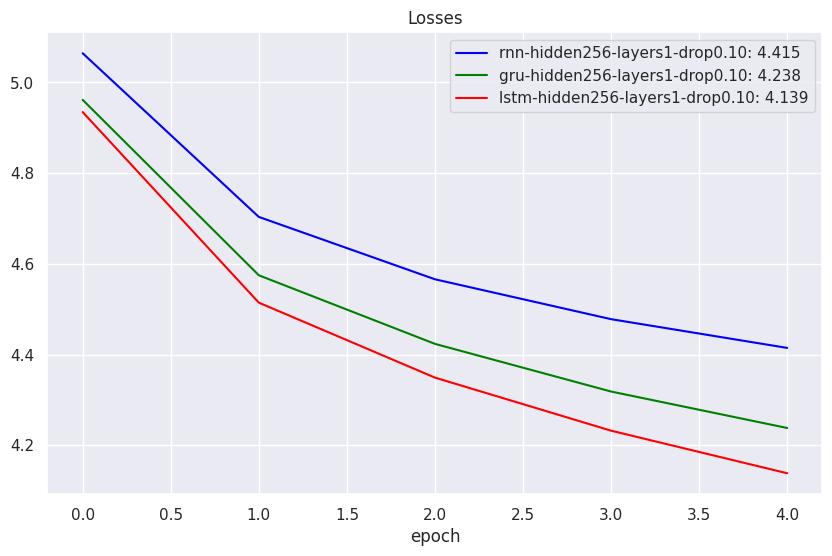

In [ ]:
import matplotlib
colors = list(matplotlib.colors.BASE_COLORS) + list(matplotlib.colors.XKCD_COLORS)

plt.figure(figsize=(10,6))
for color, name in enumerate(sorted(models_type.keys(), key=lambda n:-losses_type[n][-1])):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=colors[color], label=f"{name}: {losses_type[name][-1]:.3f}")
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()


Perplexity reflects how surprised or confused the model is when it encounters new text. A lower perplexity indicates that the model is less surprised by the actual sequence of words in the text and is therefore more confident in its predictions.

Perplexity reflects how the model is "confidence" or "certainty" in its predictions. A lower perplexity suggests that the model is more certain about its predictions and has a better understanding of the language patterns in the text it is trying to predict. On the other hand, a higher perplexity indicates that the model is more uncertain and less accurate in its predictions.

In [ ]:
for name in sorted(models_type.keys()):
    perplexities = perplexities_type[name]
    print("name", name)
    print("perplexities", perplexities)
    print()

name gru-hidden256-layers1-drop0.10
perplexities [106.42072296142578, 99.1928482055664, 98.8616943359375, 100.37850952148438, 102.55973815917969]

name lstm-hidden256-layers1-drop0.10
perplexities [101.14818572998047, 92.01075744628906, 90.44493103027344, 91.58877563476562, 93.55601501464844]

name rnn-hidden256-layers1-drop0.10
perplexities [119.61764526367188, 111.88410949707031, 111.07886505126953, 111.27256774902344, 113.03919219970703]



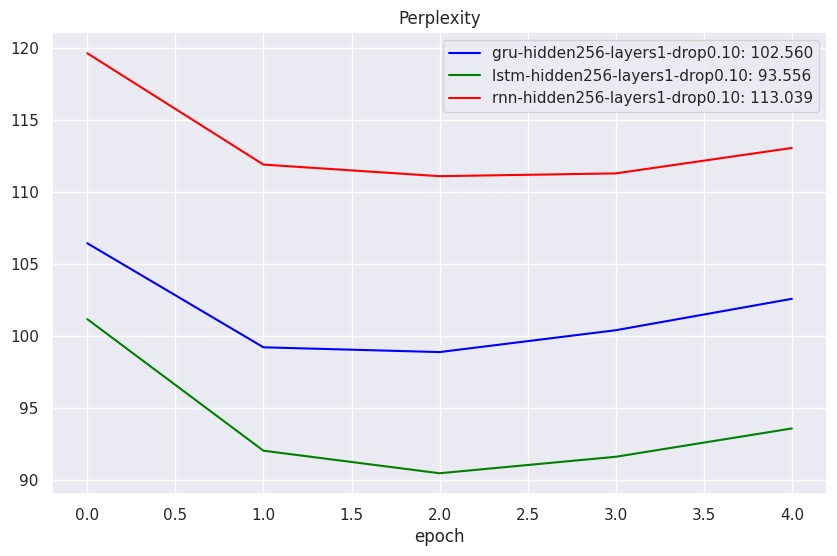

In [ ]:
plt.figure(figsize=(10, 6))

for color, name in enumerate(sorted(models_type.keys())):
    perplexities = perplexities_type[name]
    if perplexities:
      plt.plot(np.arange(len(perplexities)), perplexities, color=colors[color], label=f"{name}: {perplexities[-1]:.3f}")

plt.title('Perplexity')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
import re
def remove_angle_brackets(text):
    # Define a regular expression pattern to match text within angle brackets
    pattern = r"<.*?>"
    # Use re.sub() to replace all matches with an empty string
    clean_text = re.sub(pattern, " ", text)
    return clean_text

In [ ]:
for _ in range(3):
  random_index = random.randint(0, len(test_sentences))
  test_sentence = test_sentences[random_index]
  print("Test sentence : ", test_sentence)
  for model_type, num_layers, dropout in experiments:
    model = LanguageModel(hidden_dim = 256,
                  vocab_size = len(vocab),
                  model_type = model_type,
                  num_layers = num_layers,
                  dropout = dropout).to(device)

    if model.name in models_type:
        # Load the state dictionary back into the model
        model.load_state_dict(models_type[model.name])
        print(f"Model Type: {model_type}, Num Layers: {num_layers}, Dropout: {dropout}")
        print(generate_sequence(model, starting_seq=test_sentence))
    else:
        print(f"No saved model found for {model.name}")

  print("--------------------------------------------------------------------------------")

Test sentence :  bad acting, bad dialogue, and atrociously directed.
Model Type: rnn, Num Layers: 1, Dropout: 0.1
<bos> bad acting <unk> bad dialogue <unk> and atrociously directed <unk> and the direction is <unk> <unk> <unk> <eos>
Model Type: gru, Num Layers: 1, Dropout: 0.1
<bos> bad acting <unk> bad dialogue <unk> and atrociously directed <unk> <eos>
Model Type: lstm, Num Layers: 1, Dropout: 0.1
<bos> bad acting <unk> bad dialogue <unk> and atrociously directed <unk> <eos>
--------------------------------------------------------------------------------
Test sentence :  it seems it was more a movie from the early 50's or 60's.
Model Type: rnn, Num Layers: 1, Dropout: 0.1
<bos> it seems it was more <unk> movie from the early 50 's or 60 's <unk> <eos>
Model Type: gru, Num Layers: 1, Dropout: 0.1
<bos> it seems it was more <unk> movie from the early 50 's or 60 's <unk> <eos>
Model Type: lstm, Num Layers: 1, Dropout: 0.1
<bos> it seems it was more <unk> movie from the early 50 's or 60

### Conclusion


I experimented with several models and attempted to increase the number of layers, but I didn't have the opportunity to try it with Layer/Batch Norm, so the results weren't great. The results from the three models I tried with limited GPU resources (meaning I ran only for 5 epochs and trained only on 30% of my train set) in this notebook are:
#### LSTM:

Hidden size: 256
Layers: 1
Dropout: 0.10
Perplexities: [101.15, 92.01, 90.44, 91.59, 93.56]

#### GRU:

Hidden size: 256
Layers: 1
Dropout: 0.10
Perplexities: [106.42, 99.19, 98.86, 100.38, 102.56]

#### RNN:

Hidden size: 256
Layers: 1
Dropout: 0.10
Perplexities: [119.62, 111.88, 111.08, 111.27, 113.04]

The LSTM model yielded the best results among the models I experimented with. However, the performance is still far from satisfactory.

The decreasing losses indicate progress, and I anticipate achieving even better results by training for more epochs.

I plan to run more epochs using all the available training data. With a larger dataset, I anticipate achieving better results, especially with RNNs with several layers  +  Layer/Batch Normalization which potentially improve the performance of models with multiple layers.


Utilizing softmax on the logits during the final step of the forward pass is a standard approach in language modeling endeavors. Hence, I plan to explore the incorporation of softmax (F.softmax(logits, dim=-1)) into my experiments.




